#### Tasks:

go to https://github.com/miaow1988/SqueezeNet_v1.2 and download the 'symbol.json' and '.params' files (there is not a 'synset.txt' file! so don't use these lines, Hint: just comment these lines).

* Install MXNet v1.5 (hint: create a new conda environmet with python 3, pip install mxnet==1.5.1) and follow the same steps of the lecture (part: *Using pre-trained models as feature extractors*). Find the flatten output layer and create a feature extractor (hint: It should be a numpy array of 1000 elements).
* Download the dogs versus cats *training folder* from https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data (Remember the number of images is 12500 for each class).
* Extract the array of features for different number of images (N: 10, 100, 500, 1000, also 5000 and 12500) and for each value train your favorite binary classifier (only one!!!) using GridSearch to optimize some hyperparameters. Consider to use https://notebooks.csc.fi if you have computational limitations. 

* Report the accuracy for each value of N and the computational time during the training step.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from __future__ import print_function # compatibility with python 2
import mxnet as mx
import numpy as np
from mxnet import nd, autograd
from mxnet import gluon

# lets define first if we want to use cpu or gpu.
# Note: don't use gpu on small projects, it is a waste of resources!

ctx = mx.cpu()
# or if you're lucky enough!
#ctx = mx.gpu()

C:\Hyapp\Anaconda3-2022.05\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from os import listdir
from os.path import isfile, join
import os

mypath = join(os.getcwd(),'data/dogs-vs-cats/train/train')

cats_imgs = [join(mypath,f) for f in listdir(mypath) if f.startswith('cat')]
dogs_imgs = [join(mypath,f) for f in listdir(mypath) if f.startswith('dog')]

In [3]:
print("cats: {} and dogs: {}".format(len(cats_imgs),len(dogs_imgs)))

cats: 12500 and dogs: 12500


In [4]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
# define a simple data batch
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

In [5]:
sym, arg_params, aux_params = mx.model.load_checkpoint('pretrained/resnet-152', 0)
mod = mx.mod.Module(symbol=sym, context=mx.cpu(), label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)
with open('pretrained/synset.txt', 'r') as f:
    labels = [l.rstrip() for l in f]

In [6]:
def get_image(url, show=False):
    if url.startswith('http'):
        # download and show the image
        fname = mx.test_utils.download(url)
    else:
        fname = url
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    if img is None:
         return None
    if show:
         plt.imshow(img)
         plt.axis('off')
    # convert into format (batch, RGB, width, height)
    img = cv2.resize(img, (224, 224))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]
    return img

def predict(url):
    img = get_image(url, show=True)
    # compute the predict probabilities
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    # print the top-5
    prob = np.squeeze(prob)
    a = np.argsort(prob)[::-1]
    for i in a[0:5]:
        print('probability=%f, class=%s' %(prob[i], labels[i]))

In [7]:
# list the last 10 layers
all_layers = sym.get_internals()
all_layers.list_outputs()[-10:]

['bn1_moving_var',
 'bn1_output',
 'relu1_output',
 'pool1_output',
 'flatten0_output',
 'fc1_weight',
 'fc1_bias',
 'fc1_output',
 'softmax_label',
 'softmax_output']

In [8]:
fe_sym = all_layers['flatten0_output']
fe_mod = mx.mod.Module(symbol=fe_sym, context=mx.cpu(), label_names=None)
fe_mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
fe_mod.set_params(arg_params, aux_params)

In [9]:
def get_features(img):
    fe_mod.forward(Batch([mx.nd.array(img)]))
    features = fe_mod.get_outputs()[0].asnumpy()
    return features

#### N=10

In [10]:
Nmax = 10
cats_features = [get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax]]
dogs_features = [get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax]]

In [11]:
Y_cats = np.array(Nmax * [1])
Y_dogs = np.array(Nmax * [0])

In [12]:
X_cvd = np.vstack([cats_features,dogs_features])
Y_cvd = np.vstack([Y_cats,Y_dogs]).ravel()

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_cvd, Y_cvd, random_state=42)

In [14]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression().fit(X_train, y_train)

print("Test set score: {:.2f}".format(lg.score(X_test, y_test)))

Test set score: 1.00


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10,120],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(SVC(), param_grid, cv=5)
X_train, X_test, y_train, y_test = train_test_split(X_cvd, Y_cvd, random_state=0)
grid_search.fit(X_train, y_train)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}\n".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Test set score: 1.00
Best parameters: {'C': 1, 'gamma': 0.001}
Best cross-validation score: 1.00

Best estimator:
SVC(C=1, gamma=0.001)


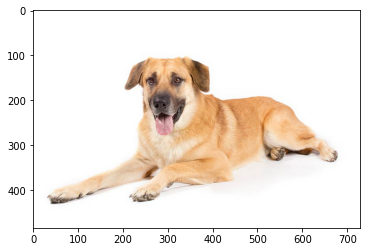

In [16]:
import matplotlib.image as mpimg

dog_test_path = join(os.getcwd(),'Chinook-On-White-03.jpg')
cat_test_path = join(os.getcwd(),'Thinking-of-getting-a-cat.png')

img = mpimg.imread(dog_test_path)
imgplot = plt.imshow(img)
plt.show()

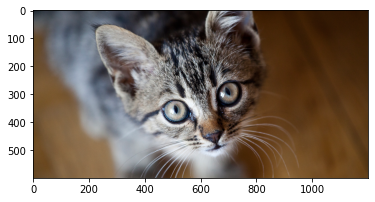

In [17]:
img = mpimg.imread(cat_test_path)
imgplot = plt.imshow(img)
plt.show()

In [18]:
features_out = get_features(get_image(dog_test_path))

prob = lg.predict_proba(features_out)
pred = lg.predict(features_out)

if pred[0] == 1:
    fpred = 'cat'
else:
    fpred = 'dog'
    
print("prob: {} and prediction: {}".format(prob,fpred))

prob: [[0.99250809 0.00749191]] and prediction: dog


#### N=100

In [33]:
Nmax = 100
cats_features = [get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax]]
dogs_features = [get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax]]

In [34]:
Y_cats = np.array(Nmax * [1])
Y_dogs = np.array(Nmax * [0])

In [35]:
X_cvd = np.vstack([cats_features,dogs_features])
Y_cvd = np.vstack([Y_cats,Y_dogs]).ravel()

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_cvd, Y_cvd, random_state=42)

In [37]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression().fit(X_train, y_train)

print("Test set score: {:.2f}".format(lg.score(X_test, y_test)))

Test set score: 0.98


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10,120],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(SVC(), param_grid, cv=5)
X_train, X_test, y_train, y_test = train_test_split(X_cvd, Y_cvd, random_state=0)
grid_search.fit(X_train, y_train)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}\n".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Test set score: 0.98
Best parameters: {'C': 1, 'gamma': 0.001}
Best cross-validation score: 0.99

Best estimator:
SVC(C=1, gamma=0.001)


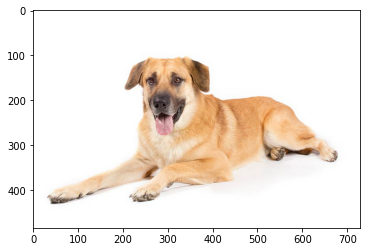

In [39]:
import matplotlib.image as mpimg

dog_test_path = join(os.getcwd(),'Chinook-On-White-03.jpg')
cat_test_path = join(os.getcwd(),'Thinking-of-getting-a-cat.png')

img = mpimg.imread(dog_test_path)
imgplot = plt.imshow(img)
plt.show()

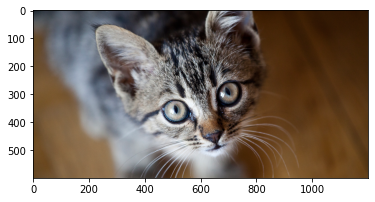

In [40]:
img = mpimg.imread(cat_test_path)
imgplot = plt.imshow(img)
plt.show()

In [41]:
features_out = get_features(get_image(dog_test_path))

prob = lg.predict_proba(features_out)
pred = lg.predict(features_out)

if pred[0] == 1:
    fpred = 'cat'
else:
    fpred = 'dog'
    
print("prob: {} and prediction: {}".format(prob,fpred))

prob: [[9.99409155e-01 5.90844722e-04]] and prediction: dog


#### N=500

In [42]:
Nmax = 500
cats_features = [get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax]]
dogs_features = [get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax]]

In [43]:
Y_cats = np.array(Nmax * [1])
Y_dogs = np.array(Nmax * [0])

In [44]:
X_cvd = np.vstack([cats_features,dogs_features])
Y_cvd = np.vstack([Y_cats,Y_dogs]).ravel()

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_cvd, Y_cvd, random_state=42)

In [46]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression().fit(X_train, y_train)

print("Test set score: {:.2f}".format(lg.score(X_test, y_test)))

Test set score: 1.00


C:\Hyapp\Anaconda3-2022.05\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10,120],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(SVC(), param_grid, cv=5)
X_train, X_test, y_train, y_test = train_test_split(X_cvd, Y_cvd, random_state=0)
grid_search.fit(X_train, y_train)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}\n".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Test set score: 0.99
Best parameters: {'C': 1, 'gamma': 0.001}
Best cross-validation score: 0.99

Best estimator:
SVC(C=1, gamma=0.001)


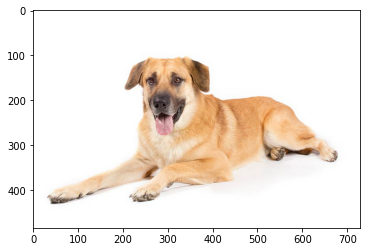

In [48]:
import matplotlib.image as mpimg

dog_test_path = join(os.getcwd(),'Chinook-On-White-03.jpg')
cat_test_path = join(os.getcwd(),'Thinking-of-getting-a-cat.png')

img = mpimg.imread(dog_test_path)
imgplot = plt.imshow(img)
plt.show()

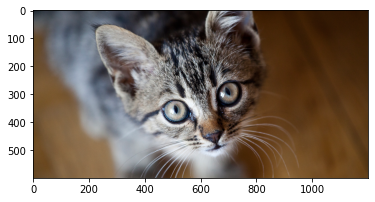

In [49]:
img = mpimg.imread(cat_test_path)
imgplot = plt.imshow(img)
plt.show()

In [50]:
features_out = get_features(get_image(dog_test_path))

prob = lg.predict_proba(features_out)
pred = lg.predict(features_out)

if pred[0] == 1:
    fpred = 'cat'
else:
    fpred = 'dog'
    
print("prob: {} and prediction: {}".format(prob,fpred))

prob: [[9.99995985e-01 4.01462254e-06]] and prediction: dog


#### N=1000

In [51]:
Nmax = 1000
cats_features = [get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax]]
dogs_features = [get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax]]

In [52]:
Y_cats = np.array(Nmax * [1])
Y_dogs = np.array(Nmax * [0])

In [53]:
X_cvd = np.vstack([cats_features,dogs_features])
Y_cvd = np.vstack([Y_cats,Y_dogs]).ravel()

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_cvd, Y_cvd, random_state=42)

In [55]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression().fit(X_train, y_train)

print("Test set score: {:.2f}".format(lg.score(X_test, y_test)))

Test set score: 0.99


C:\Hyapp\Anaconda3-2022.05\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10,120],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(SVC(), param_grid, cv=5)
X_train, X_test, y_train, y_test = train_test_split(X_cvd, Y_cvd, random_state=0)
grid_search.fit(X_train, y_train)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}\n".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Test set score: 0.99
Best parameters: {'C': 10, 'gamma': 0.001}
Best cross-validation score: 0.99

Best estimator:
SVC(C=10, gamma=0.001)


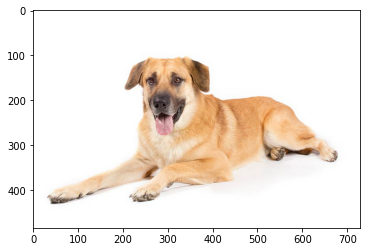

In [57]:
import matplotlib.image as mpimg

dog_test_path = join(os.getcwd(),'Chinook-On-White-03.jpg')
cat_test_path = join(os.getcwd(),'Thinking-of-getting-a-cat.png')

img = mpimg.imread(dog_test_path)
imgplot = plt.imshow(img)
plt.show()

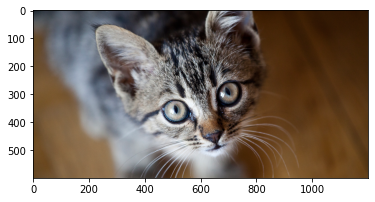

In [58]:
img = mpimg.imread(cat_test_path)
imgplot = plt.imshow(img)
plt.show()

In [59]:
features_out = get_features(get_image(dog_test_path))

prob = lg.predict_proba(features_out)
pred = lg.predict(features_out)

if pred[0] == 1:
    fpred = 'cat'
else:
    fpred = 'dog'
    
print("prob: {} and prediction: {}".format(prob,fpred))

prob: [[9.99957795e-01 4.22046149e-05]] and prediction: dog


We can see that best test score achieved 1.0  with N=10 with best estimatorSVC(C=1, gamma=0.001)
In case of N=100 , Test set score: 0.98 Best estimator:SVC(C=1, gamma=0.001)
In case of N=500 , Test set score: 0.99, Best estimator:SVC(C=1, gamma=0.001)   
In case of N=1000, Test set score: 0.99 Best estimator:SVC(C=10, gamma=0.001)   